In [18]:
%load_ext autoreload
%autoreload 2
from functools import partial
from collections import OrderedDict, defaultdict

from datasets import load_dataset
from more_itertools import chunked
from tqdm.auto import tqdm
import torch as t
import numpy as np

t.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import gc

def free_unused_cuda_memory():
    gc.collect()
    if t.cuda.is_available():
        if t.cuda.device_count() > 1:
            t.cuda.synchronize()
        t.cuda.empty_cache()
    else:
        raise RuntimeError("CUDA not found!")

## Initialize

In [3]:
from diffusers import FluxPipeline

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=t.bfloat16, device_map="balanced")
pipe_dev = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=t.bfloat16, device_map="balanced")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
prompts_dataset = load_dataset("opendiffusionai/cc12m-cleaned", split="train").select(range(100))
prompts_iter = prompts_dataset["caption_llava_short"]

guidance_scale = 3.5
num_inference_steps = 1
batch_size = 32
width = 512
height = 512
d_model = 3072


for i, prompts in enumerate(chunked((bar := tqdm(prompts_iter)), batch_size)):
    timestep = 0

    def callback_on_step_end(self, i, t, kwargs):
        global timestep
        timestep = i
        return {}
        
    with t.inference_mode():
        pipe.set_progress_bar_config(disable=True) 
        with t.inference_mode():
            latents = pipe(
                prompts,
                height=height,
                width=width,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                max_sequence_length=512,
                generator=t.Generator("cpu").manual_seed(0),
                return_dict=False,
                callback_on_step_end=callback_on_step_end,
                output_type="latent",
            )[0]
    break

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
(
    prompt_embeds,
    pooled_prompt_embeds,
    text_ids,
) = pipe.encode_prompt(
    prompt=prompts,
    prompt_2=None,
    prompt_embeds=None,
    pooled_prompt_embeds=None,
    device=None,
    num_images_per_prompt=1,
    max_sequence_length=512,
    lora_scale=0.0,
)

In [ ]:
from tqdm import trange
    
text_norms = defaultdict(list)
image_norms = defaultdict(list)
text_cossims = defaultdict(list)
image_cossims = defaultdict(list)
schnell_text = {}
schnell_image = {}


for m in pipe.transformer.modules():
    m._forward_hooks = OrderedDict()
for m in pipe_dev.transformer.modules():
    m._forward_hooks = OrderedDict()

def save_hook(self, input, output, l):
    text_output, image_output = output
    text_norm, image_norm = t.norm(text_output, dim=-1, p=2).mean(), t.norm(image_output, dim=-1, p=2).mean()
    key = (current_model, l, timestep)
    text_norms[key].append(text_norm.item())
    image_norms[key].append(image_norm.item())
    if l in schnell_image:
        other = schnell_image.pop(l).to(image_output.device)
        cossim = t.nn.functional.cosine_similarity(image_output.flatten(0, 1), other.flatten(0, -2), dim=-1).mean()
        image_cossims[l].append(cossim.item())
    if l in schnell_text:
        other = schnell_text.pop(l).to(text_output.device)
        cossim = t.nn.functional.cosine_similarity(text_output.flatten(0, 1), other.flatten(0, -2), dim=-1).mean()
        text_cossims[l].append(cossim.item())
    schnell_text[l] = text_output
    schnell_image[l] = image_output


for l in range(len(pipe.transformer.transformer_blocks)):
    pipe.transformer.transformer_blocks[l].register_forward_hook(partial(save_hook, l=l))
    pipe_dev.transformer.transformer_blocks[l].register_forward_hook(partial(save_hook, l=l))

with t.inference_mode():
    noise = t.randn_like(latents)
    guidance = t.tensor([3.5]).to(latents).expand(latents.shape[0])
    height_ = 2 * (int(height) // (pipe.vae_scale_factor * 2))
    width_ = 2 * (int(width) // (pipe.vae_scale_factor * 2))
    latent_image_ids = pipe._prepare_latent_image_ids(batch_size, height_ // 2, width_ // 2, latents.device, latents.dtype)
    num_test_steps = 6

    
    for i in trange(1, num_test_steps + 1):
        timestep = i / num_test_steps
        ts = t.tensor([timestep]).to(latents)
        mixed = (1 - ts) * latents + ts * noise

        @t.inference_mode
        def decode_latent(noise_pred, p):
            denoised = (mixed - noise_pred * ts) / (1 - ts)
            latents = p._unpack_latents(denoised, height, width, p.vae_scale_factor)
            latents = (latents / p.vae.config.scaling_factor) + p.vae.config.shift_factor
            image = p.vae.decode(latents, return_dict=False)[0]
            image = p.image_processor.postprocess(image, output_type="pil")
            return image[0]

        current_model = "schnell"
        pipe.transformer(
            mixed,
            timestep=ts,
            guidance=None,
            pooled_projections=pooled_prompt_embeds,
            encoder_hidden_states=prompt_embeds,
            txt_ids=text_ids,
            img_ids=latent_image_ids,
            joint_attention_kwargs=pipe.joint_attention_kwargs,
            return_dict=False,
        )[0]
        current_model = "dev"
        noise_pred = pipe_dev.transformer(
            mixed,
            timestep=ts,
            guidance=guidance,
            pooled_projections=pooled_prompt_embeds,
            encoder_hidden_states=prompt_embeds,
            txt_ids=text_ids,
            img_ids=latent_image_ids,
            joint_attention_kwargs=pipe.joint_attention_kwargs,
            return_dict=False,
        )[0]
        schnell_text = {}
        schnell_image = {}
        display(decode_latent(noise_pred, pipe_dev))


In [ ]:
# plots
# 1. norm over layer for different timesteps (different plots)
# 2. norm over timestep
# 3. cossim over layer for different timesteps (different plots)

## FLUX.1 Schnell

In [ ]:
import matplotlib.pyplot as plt

layers = sorted({key[1] for key in text_norms.keys() if key[0] == "schnell"})
timesteps = sorted({key[2] for key in text_norms.keys() if key[0] == "schnell"})

for t in timesteps:
    plt.figure()
    
    text_layer_norms = []
    for l in layers:
        data = text_norms.get(("schnell", l, t), [])
        if len(data) > 0:
            mean_val = sum(data) / len(data)
        else:
            mean_val = float('nan')
        text_layer_norms.append(mean_val)
    
    shifted_layers = [l + 1 for l in layers]
    plt.plot(shifted_layers, text_layer_norms)
    plt.xlabel("Layer")
    step = max(1, len(shifted_layers) // 15) 
    plt.xticks(shifted_layers[::step])
    plt.ylabel("Text Norm")
    plt.title(f"Schnell Model - Text Norm over Layers (timestep={t:.2f})")
    filename = f"outputs/text_norm_timestep_{t:.2f}.png"
    plt.savefig(filename)
    plt.show()

for t in timesteps:
    plt.figure()
    
    image_layer_norms = []
    for l in layers:
        data = image_norms.get(("schnell", l, t), [])
        if len(data) > 0:
            mean_val = sum(data) / len(data)
        else:
            mean_val = float('nan')
        image_layer_norms.append(mean_val)
    
    shifted_layers = [l + 1 for l in layers]
    plt.plot(shifted_layers, image_layer_norms)
    plt.xlabel("Layer")
    step = max(1, len(shifted_layers) // 15) 
    plt.xticks(shifted_layers[::step])
    plt.ylabel("Image Norm")
    plt.title(f"Schnell Model - Image Norm over Layers (timestep={t:.2f})")
    filename = f"outputs/image_norm_timestep_{t:.2f}.png"
    plt.savefig(filename)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

text_norm_matrix = np.array([
    [sum(text_norms.get(("schnell", l, t), [])) / len(text_norms.get(("schnell", l, t), [])) if text_norms.get(("schnell", l, t), []) else float('nan') 
     for t in timesteps] for l in layers
])

plt.figure(figsize=(10, 10))
sns.heatmap(text_norm_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=[f"{t:.2f}" for t in timesteps], yticklabels=[l+1 for l in layers])
plt.xlabel("Timestep")
plt.ylabel("Layer")
plt.title("Schnell Model - Text Norm Over Timestep by Layer")
plt.show()


In [ ]:
image_norm_matrix = np.array([
    [sum(image_norms.get(("schnell", l, t), [])) / len(image_norms.get(("schnell", l, t), [])) if image_norms.get(("schnell", l, t), []) else float('nan') 
     for t in timesteps] for l in layers
])

plt.figure(figsize=(10, 10))
sns.heatmap(image_norm_matrix, annot=True, fmt=".2f", cmap="magma", xticklabels=[f"{t:.2f}" for t in timesteps], yticklabels=[l+1 for l in layers])
plt.xlabel("Timestep")
plt.ylabel("Layer")
plt.title("Schnell Model - Image Norm Over Timestep by Layer")
plt.show()

## FLUX.1 Dev

In [ ]:
import matplotlib.pyplot as plt

layers = sorted({key[1] for key in text_norms.keys() if key[0] == "dev"})
timesteps = sorted({key[2] for key in text_norms.keys() if key[0] == "dev"})

for t in timesteps:
    plt.figure()
    
    text_layer_norms = []
    for l in layers:
        data = text_norms.get(("dev", l, t), [])
        if len(data) > 0:
            mean_val = sum(data) / len(data)
        else:
            mean_val = float('nan')
        text_layer_norms.append(mean_val)
    
    shifted_layers = [l + 1 for l in layers]
    plt.plot(shifted_layers, text_layer_norms)
    plt.xlabel("Layer")
    step = max(1, len(shifted_layers) // 15) 
    plt.xticks(shifted_layers[::step])
    plt.ylabel("Text Norm")
    plt.title(f"Dev Model - Text Norm over Layers (timestep={t:.2f})")
    filename = f"outputs/text_norm_timestep_{t:.2f}.png"
    plt.savefig(filename)
    plt.show()

for t in timesteps:
    plt.figure()
    
    image_layer_norms = []
    for l in layers:
        data = image_norms.get(("dev", l, t), [])
        if len(data) > 0:
            mean_val = sum(data) / len(data)
        else:
            mean_val = float('nan')
        image_layer_norms.append(mean_val)
    
    shifted_layers = [l + 1 for l in layers]
    plt.plot(shifted_layers, image_layer_norms)
    plt.xlabel("Layer")
    step = max(1, len(shifted_layers) // 15) 
    plt.xticks(shifted_layers[::step])
    plt.ylabel("Image Norm")
    plt.title(f"Dev Model - Image Norm over Layers (timestep={t:.2f})")
    filename = f"outputs/image_norm_timestep_{t:.2f}.png"
    plt.savefig(filename)
    plt.show()

In [ ]:
text_norm_matrix = np.array([
    [sum(text_norms.get(("dev", l, t), [])) / len(text_norms.get(("dev", l, t), [])) if text_norms.get(("dev", l, t), []) else float('nan') 
     for t in timesteps] for l in layers
])

plt.figure(figsize=(10, 10))
sns.heatmap(text_norm_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=[f"{t:.2f}" for t in timesteps], yticklabels=[l+1 for l in layers])
plt.xlabel("Timestep")
plt.ylabel("Layer")
plt.title("Dev Model - Text Norm Over Timestep by Layer")
plt.show()


In [ ]:
image_norm_matrix = np.array([
    [sum(image_norms.get(("dev", l, t), [])) / len(image_norms.get(("dev", l, t), [])) if image_norms.get(("dev", l, t), []) else float('nan') 
     for t in timesteps] for l in layers
])

plt.figure(figsize=(10, 10))
sns.heatmap(image_norm_matrix, annot=True, fmt=".2f", cmap="magma", xticklabels=[f"{t:.2f}" for t in timesteps], yticklabels=[l+1 for l in layers])
plt.xlabel("Timestep")
plt.ylabel("Layer")
plt.title("Dev Model - Image Norm Over Timestep by Layer")
plt.show()

## Cross-Comparison Analysis

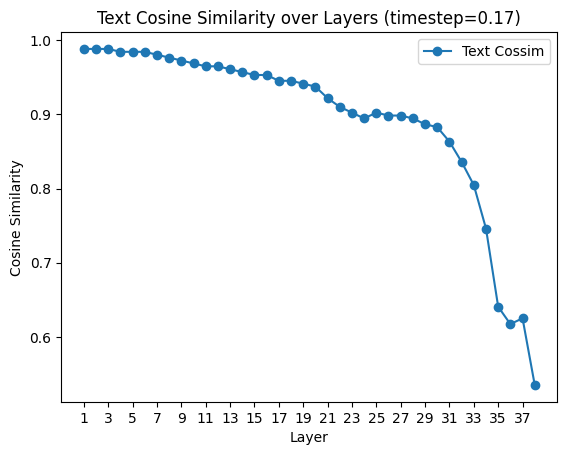

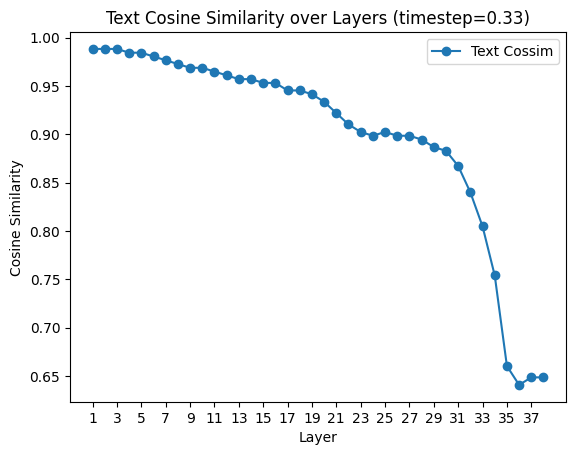

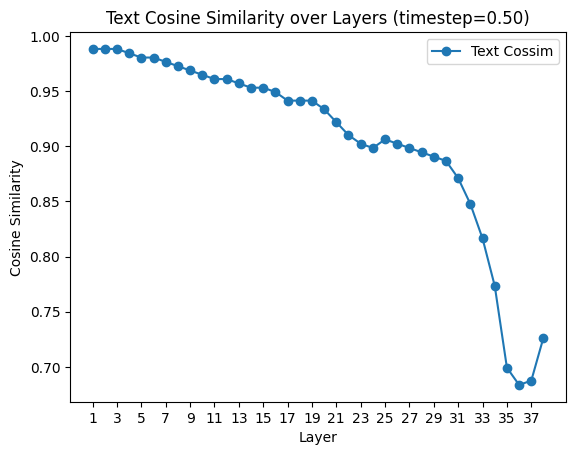

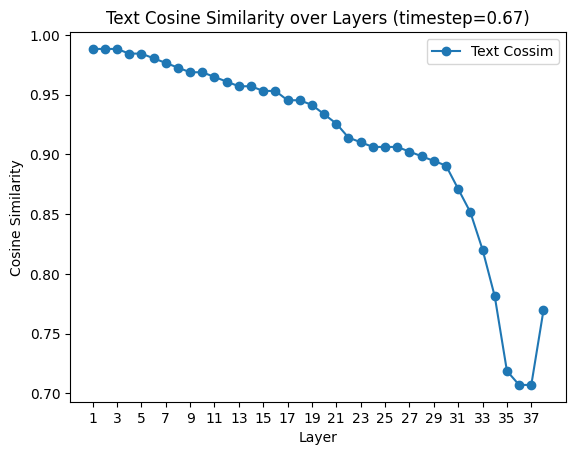

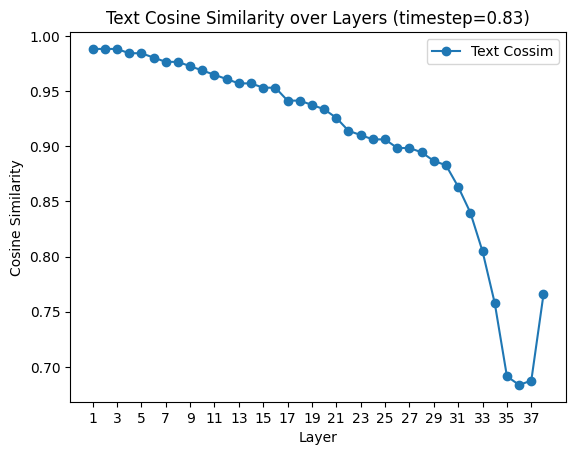

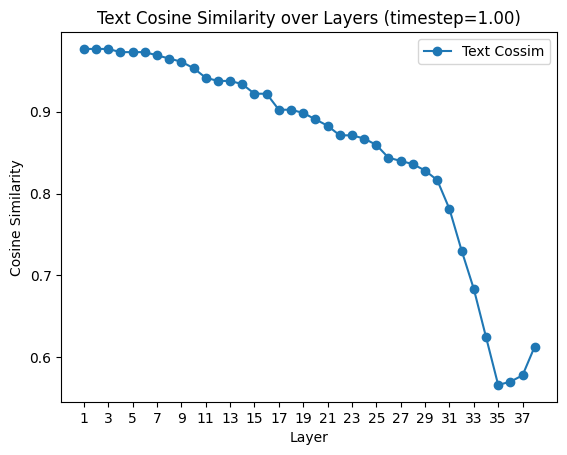

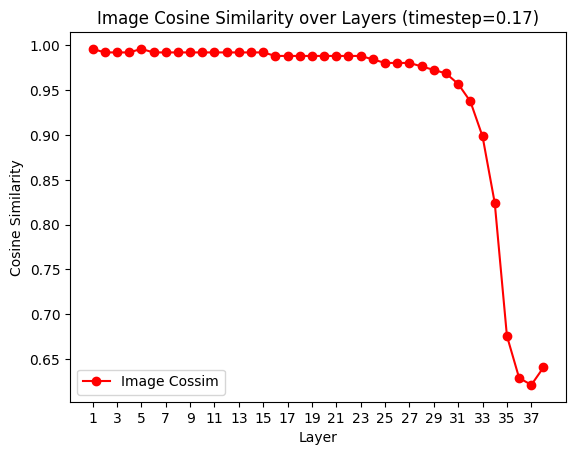

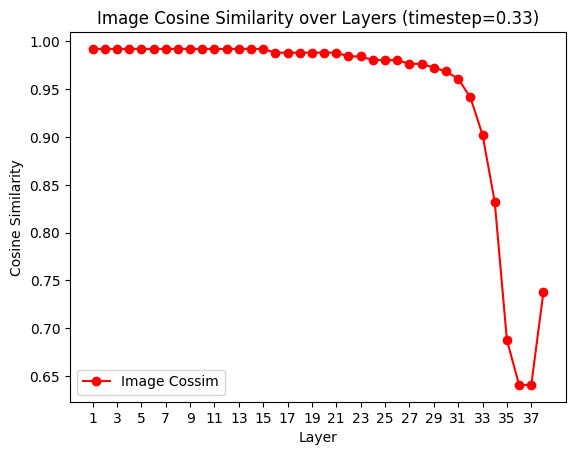

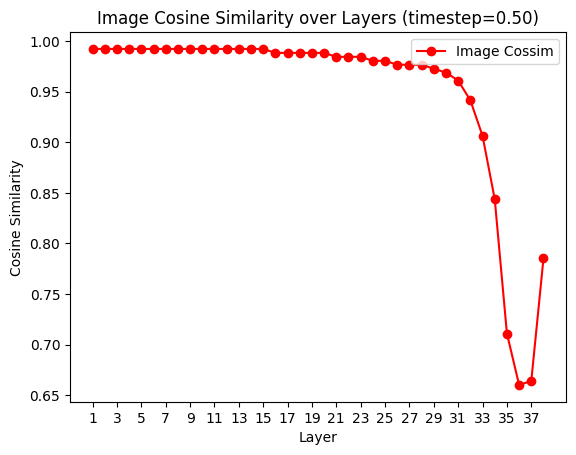

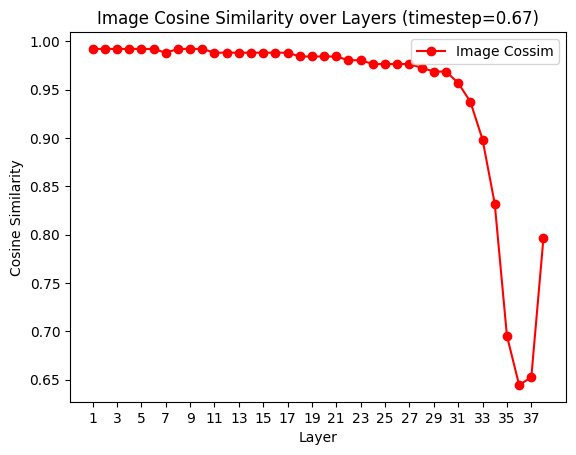

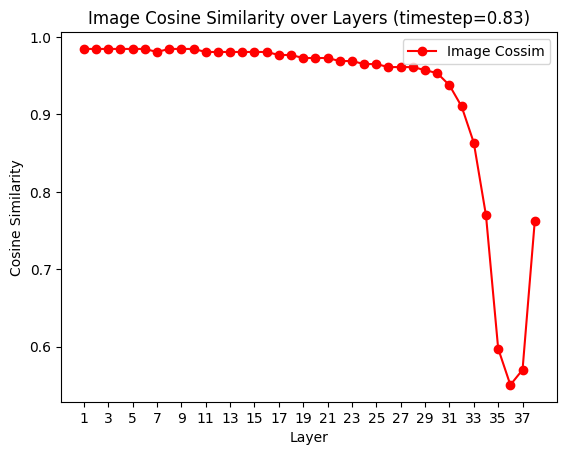

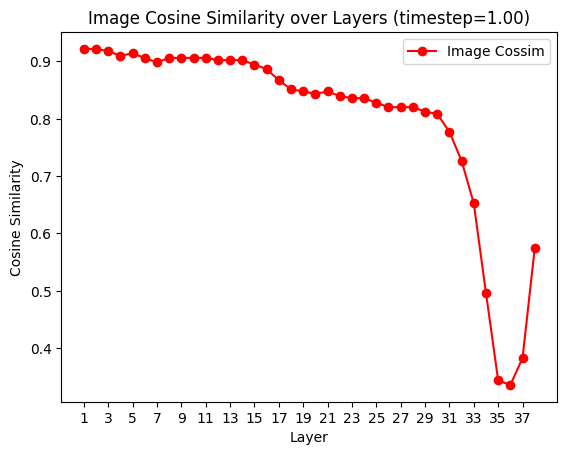

In [ ]:
import matplotlib.pyplot as plt

layers = sorted(text_cossims.keys())
timesteps = sorted({key[2] for key in text_norms.keys() if key[0] == "schnell"})

for i, t in enumerate(timesteps):
    plt.figure()
    
    text_layer_cossims = [text_cossims[l][i] for l in layers]
    
    shifted_layers = [l + 1 for l in layers]
    plt.plot(shifted_layers, text_layer_cossims, marker='o', label='Text Cossim')
    plt.xlabel("Layer")
    step = max(1, len(shifted_layers) // 15) 
    plt.xticks(shifted_layers[::step])
    plt.ylabel("Cosine Similarity")
    plt.title(f"Text Cosine Similarity over Layers (timestep={t:.2f})")
    filename = f"outputs/single_block/cosine_similarities/text_cos_sim_{t:.2f}.png"
    plt.savefig(filename)
    plt.show()

for i, t in enumerate(timesteps):
    plt.figure()
    
    image_layer_cossims = [image_cossims[l][i] for l in layers]
    
    shifted_layers = [l + 1 for l in layers]
    plt.plot(shifted_layers, image_layer_cossims, marker='o', label='Image Cossim', color='red')
    plt.xlabel("Layer")
    plt.xticks(shifted_layers)
    step = max(1, len(shifted_layers) // 15) 
    plt.xticks(shifted_layers[::step])
    plt.ylabel("Cosine Similarity")
    plt.title(f"Image Cosine Similarity over Layers (timestep={t:.2f})")
    filename = f"outputs/single_block/cosine_similarities/image_cos_sim_{t:.2f}.png"
    plt.savefig(filename)
    plt.show()


## Single Block Analysis

In [ ]:
from tqdm import trange
    
text_norms = defaultdict(list)
image_norms = defaultdict(list)
text_cossims = defaultdict(list)
image_cossims = defaultdict(list)
schnell_text = {}
schnell_image = {}


for m in pipe.transformer.modules():
    m._forward_hooks = OrderedDict()
for m in pipe_dev.transformer.modules():
    m._forward_hooks = OrderedDict()

def save_hook(self, input, output, l):
    text_output, image_output = output[..., :512, :], output[..., 512:, :]
    text_norm, image_norm = t.norm(text_output, dim=-1, p=2).mean(), t.norm(image_output, dim=-1, p=2).mean()
    key = (current_model, l, timestep)
    text_norms[key].append(text_norm.item())
    image_norms[key].append(image_norm.item())
    if l in schnell_image:
        other = schnell_image.pop(l).to(image_output.device)
        cossim = t.nn.functional.cosine_similarity(image_output.flatten(0, 1), other.flatten(0, -2), dim=-1).mean()
        image_cossims[l].append(cossim.item())
    if l in schnell_text:
        other = schnell_text.pop(l).to(text_output.device)
        cossim = t.nn.functional.cosine_similarity(text_output.flatten(0, 1), other.flatten(0, -2), dim=-1).mean()
        text_cossims[l].append(cossim.item())
    schnell_text[l] = text_output
    schnell_image[l] = image_output


for l in range(len(pipe.transformer.single_transformer_blocks)):
    pipe.transformer.single_transformer_blocks[l].register_forward_hook(partial(save_hook, l=l))
    pipe_dev.transformer.single_transformer_blocks[l].register_forward_hook(partial(save_hook, l=l))

with t.inference_mode():
    noise = t.randn_like(latents)
    guidance = t.tensor([3.5]).to(latents).expand(latents.shape[0])
    height_ = 2 * (int(height) // (pipe.vae_scale_factor * 2))
    width_ = 2 * (int(width) // (pipe.vae_scale_factor * 2))
    latent_image_ids = pipe._prepare_latent_image_ids(batch_size, height_ // 2, width_ // 2, latents.device, latents.dtype)
    num_test_steps = 6

    
    for i in trange(1, num_test_steps + 1):
        timestep = i / num_test_steps
        ts = t.tensor([timestep]).to(latents)
        mixed = (1 - ts) * latents + ts * noise

        @t.inference_mode
        def decode_latent(noise_pred, p):
            denoised = (mixed - noise_pred * ts) / (1 - ts)
            latents = p._unpack_latents(denoised, height, width, p.vae_scale_factor)
            latents = (latents / p.vae.config.scaling_factor) + p.vae.config.shift_factor
            image = p.vae.decode(latents, return_dict=False)[0]
            image = p.image_processor.postprocess(image, output_type="pil")
            return image[0]

        current_model = "schnell"
        pipe.transformer(
            mixed,
            timestep=ts,
            guidance=None,
            pooled_projections=pooled_prompt_embeds,
            encoder_hidden_states=prompt_embeds,
            txt_ids=text_ids,
            img_ids=latent_image_ids,
            joint_attention_kwargs=pipe.joint_attention_kwargs,
            return_dict=False,
        )[0]
        current_model = "dev"
        noise_pred = pipe_dev.transformer(
            mixed,
            timestep=ts,
            guidance=guidance,
            pooled_projections=pooled_prompt_embeds,
            encoder_hidden_states=prompt_embeds,
            txt_ids=text_ids,
            img_ids=latent_image_ids,
            joint_attention_kwargs=pipe.joint_attention_kwargs,
            return_dict=False,
        )[0]
        schnell_text = {}
        schnell_image = {}
        display(decode_latent(noise_pred, pipe_dev))